# Explorando ferramentas de análise da performance preditiva do modelo
- Train/test Split
- Estratificar o split
- Confusion Matrix
- Precision, Recall, F1 Metrics

In [22]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
hotel_df = pd.read_csv('data/tb_hotel_traintest.csv')

#### Primeiro observo quantas amostras de cada classe existem no dataset

- 71.373 Não cancelamentos. ~= 63% do dataset
- 42.036 Cancelamentos. ~= 37% do dataset

Temos um significativo desbalanceamento aqui.

In [3]:
hotel_df["is_cancelled"].value_counts()

0    71373
1    42036
Name: is_cancelled, dtype: int64

#### Vendo o que acontece ao treinar uma regressão apenas splittando o dataset

In [4]:
X = np.array(hotel_df["lead_time"]).reshape(-1, 1)
y = hotel_df["is_cancelled"]
class_names = ["not_cancelled", "cancelled"]


x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=13) # random state 13 if u know what I mean ;)

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

lr_model_balanced = LogisticRegression(class_weight='balanced')
lr_model_balanced.fit(x_train, y_train)


LogisticRegression(class_weight='balanced')

In [30]:
x_test = np.array(x_test).reshape(-1, 1)
label_true = y_test
label_pred = lr_model.predict(x_test)

print(classification_report(label_true, label_pred, target_names=class_names))

               precision    recall  f1-score   support

not_cancelled       0.67      0.89      0.77     17778
    cancelled       0.59      0.28      0.38     10575

     accuracy                           0.66     28353
    macro avg       0.63      0.58      0.57     28353
 weighted avg       0.64      0.66      0.62     28353



In [27]:
y_pred = lr_model.predict(x_test)
np.array(y_pred)
np.unique(y_pred)




array([0])

In [5]:
print(y_train.value_counts())

0    53595
1    31461
Name: is_cancelled, dtype: int64


In [6]:
pred_is_cancelled_LR_balanced = lr_model_balanced.predict_proba(x_test)[:,1]
pred_is_cancelled_LR = lr_model.predict_proba(x_test)[:,1]

O modelo balanceado produziu uma curva deslocada pra cima em relação à curva do modelo não balanceado, isso é considerado bias?

In [7]:
x_test

array([[334],
       [211],
       [ 18],
       ...,
       [  1],
       [ 66],
       [ 53]])

<AxesSubplot:>

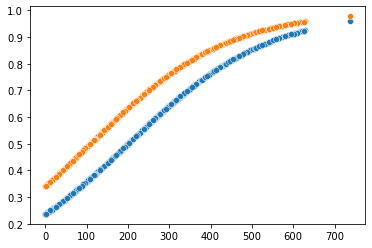

In [8]:
x_test = x_test.reshape(-1,) # Pra funcionar no scatterplot.

sns.scatterplot(x=x_test, y=pred_is_cancelled_LR) # Azul
sns.scatterplot(x=x_test, y=pred_is_cancelled_LR_balanced) # Laranja

A matriz de confusão do modelo não balanceado abaixo mostra direitinho o fenômeno de "chutar tudo como classe majoritária".

Confusion matrix not balanced
[[0.88671392 0.11328608]
 [0.72283688 0.27716312]]


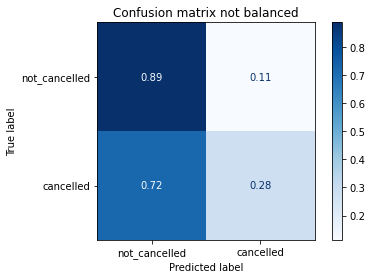

In [9]:
x_test = x_test.reshape(-1, 1) # Para funcionar na Confusion Matrix
normalize = "true"
title = "Confusion matrix not balanced"

display = ConfusionMatrixDisplay.from_estimator(
    lr_model,
    x_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=normalize,
)
display.ax_.set_title(title)

print(title)
print(display.confusion_matrix)

# plt.show()

Há uma melhora ao balancear o modelo, mas podemos ver que ainda há muitos falso negativos. Será que estratificar os splits ajuda?

Confusion matrix balanced
[[0.71279109 0.28720891]
 [0.48208038 0.51791962]]


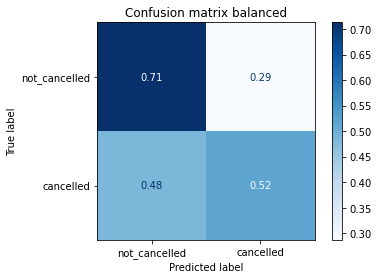

In [10]:
normalize = "true"
title = "Confusion matrix balanced"

display = ConfusionMatrixDisplay.from_estimator(
    lr_model_balanced,
    x_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=normalize,
)
display.ax_.set_title(title)

print(title)
print(display.confusion_matrix)

Estratificando os splits

In [11]:
x_train_strat, x_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, random_state=13, stratify=y)
lr_model_balanced_strat = LogisticRegression(class_weight='balanced')
lr_model_balanced_strat.fit(x_train_strat, y_train_strat)

pred_is_cancelled_LR_balanced_strat = lr_model_balanced_strat.predict_proba(x_test_strat)[:,1]

In [12]:
x_test_strat.shape

(28353, 1)

<AxesSubplot:>

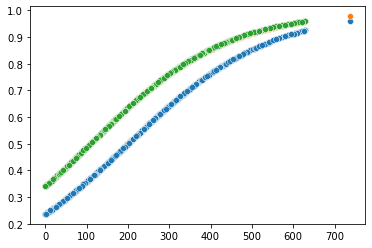

In [13]:
x_test = x_test.reshape(-1,) # Pra funcionar no scatterplot.
x_test_strat = x_test_strat.reshape(-1,) # Pra funcionar no scatterplot.

sns.scatterplot(x=x_test, y=pred_is_cancelled_LR) # Azul
sns.scatterplot(x=x_test, y=pred_is_cancelled_LR_balanced) # Laranja
sns.scatterplot(x=x_test_strat, y=pred_is_cancelled_LR_balanced_strat) # Verde

Ok, Não parece ter mudado nada :P

Na verdade ele eliminou o ultimo pontinho do outlier ali kkkkk

Confusion matrix balanced stratified
[[0.70993051 0.29006949]
 [0.48777239 0.51222761]]


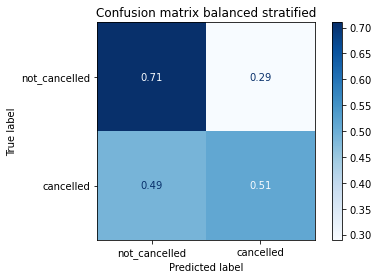

In [14]:
x_test_strat = x_test_strat.reshape(-1, 1) # Para funcionar na Confusion Matrix
normalize = "true"
title = "Confusion matrix balanced stratified"

display = ConfusionMatrixDisplay.from_estimator(
    lr_model_balanced_strat,
    x_test_strat,
    y_test_strat,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=normalize,
)
display.ax_.set_title(title)

print(title)
print(display.confusion_matrix)

Tá, e se eu não balancear e estratificar o split?

In [15]:
x_train_strat, x_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, random_state=13, stratify=y)
lr_model_strat = LogisticRegression()
lr_model_strat.fit(x_train_strat, y_train_strat)

pred_is_cancelled_LR_strat = lr_model_balanced_strat.predict_proba(x_test_strat)[:,1]

<AxesSubplot:>

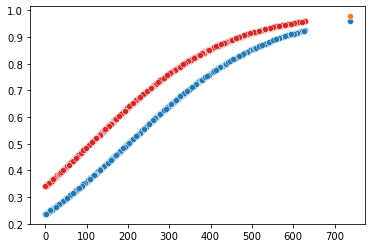

In [16]:
x_test = x_test.reshape(-1,) # Pra funcionar no scatterplot.
x_test_strat = x_test_strat.reshape(-1,) # Pra funcionar no scatterplot.

sns.scatterplot(x=x_test, y=pred_is_cancelled_LR) # Azul
sns.scatterplot(x=x_test, y=pred_is_cancelled_LR_balanced) # Laranja
sns.scatterplot(x=x_test_strat, y=pred_is_cancelled_LR_balanced_strat) # Verde
sns.scatterplot(x=x_test_strat, y=pred_is_cancelled_LR_strat) # Vermelho

Interessante, a estratificação produziu o mesmo resultado do balanceamento. Por quê?

Aqui, as curvas laranja, verde e vermelha estão sobrepostas

In [34]:
from datetime import datetime

In [38]:
today = datetime.now()
print(today.strftime("%Y-%m-%d"))


2022-08-25
